In [ ]:
] add DataFrames

In [1]:
using DrWatson
using Plots
using DataFrames
import PartitionedArraysBenchmarks as pb

In [2]:
path = mkpath("results")
cmd = :sbatch
function reduce_timing(ts)
    nworkers = length(ts)
    nruns = length(first(ts))
    t = minimum(ir->maximum(iw->ts[iw][ir],1:nworkers),1:nruns)
    t
end
filename = params -> joinpath(path,pb.jobname(params))
function parts_per_dir_array(P,D)
    cis = CartesianIndices(P)
    a = filter(cis) do ci
        t = Tuple(ci)
        issorted(t) && maximum(t)-minimum(t)<=1
    end
    map(a) do a
        ntuple(D) do d
            if d > length(P)
                return 1
            end
            Int(a[d])
        end
    end
end
function optimal(x,y)
    x1 = x[1]
    y1 = y[1]
    C = y1/x1
    K = y1 - C / x1
    C ./ x .+ K
end

optimal (generic function with 1 method)

## SpMV

In [5]:
#parts_per_dir_space = [(1,1,1)]#,(2,1,1),(3,1,1),(4,1,1),(5,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["PartitionedArrays","Petsc"]
param_space = Dict(
    :nodes => 2,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(600,600,600)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_spmv,
)

Dict{Symbol, Any} with 8 entries:
  :np              => Derived{Symbol}([:parts_per_dir], prod)
  :method          => ["PartitionedArrays", "Petsc"]
  :benchmark       => :benchmark_spmv
  :nodes           => 2
  :cells_per_dir   => [(600, 600, 600)]
  :parts_per_dir   => [(1, 1, 1), (1, 1, 2), (1, 2, 2), (2, 2, 2), (2, 2, 3), (…
  :ntasks_per_node => Derived{Symbol}([:parts_per_dir], prod)
  :nruns           => 10

In [6]:
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

[ Info: File results/1eef5d0bbabf10fb.jld2 does not exist. Producing it now...


Submitted batch job 243414
Submitted batch job 243415
Submitted batch job 243416
Submitted batch job 243417
Submitted batch job 243418


[ Info: File results/1eef5d0bbabf10fb.jld2 saved.
[ Info: File results/8a5b2e10ac37f4a0.jld2 does not exist. Producing it now...
[ Info: File results/8a5b2e10ac37f4a0.jld2 saved.
[ Info: File results/8c5a3841f76d4fa2.jld2 does not exist. Producing it now...
[ Info: File results/8c5a3841f76d4fa2.jld2 saved.
[ Info: File results/5bb336898432816f.jld2 does not exist. Producing it now...
[ Info: File results/5bb336898432816f.jld2 saved.
[ Info: File results/ab64ad839c7b1746.jld2 does not exist. Producing it now...
[ Info: File results/ab64ad839c7b1746.jld2 saved.
[ Info: File results/2673950c25a83232.jld2 does not exist. Producing it now...


Submitted batch job 243419
Submitted batch job 243420
Submitted batch job 243421
Submitted batch job 243422
Submitted batch job 243423
Submitted batch job 243424
Submitted batch job 243425


[ Info: File results/2673950c25a83232.jld2 saved.
[ Info: File results/69f3a0fd4c971325.jld2 does not exist. Producing it now...
[ Info: File results/69f3a0fd4c971325.jld2 saved.
[ Info: File results/8d4cdd0685dd2b7c.jld2 does not exist. Producing it now...
[ Info: File results/8d4cdd0685dd2b7c.jld2 saved.
[ Info: File results/f7a8e9532ef55842.jld2 does not exist. Producing it now...
[ Info: File results/f7a8e9532ef55842.jld2 saved.
[ Info: File results/b450c6f0ee6976a7.jld2 does not exist. Producing it now...
[ Info: File results/b450c6f0ee6976a7.jld2 saved.
[ Info: File results/170e0183d45c9e57.jld2 does not exist. Producing it now...
[ Info: File results/170e0183d45c9e57.jld2 saved.
[ Info: File results/b64ceabed19c7892.jld2 does not exist. Producing it now...
[ Info: File results/b64ceabed19c7892.jld2 saved.
[ Info: File results/4cd9f9bcbc9399b2.jld2 does not exist. Producing it now...


Submitted batch job 243426
Submitted batch job 243427


[ Info: File results/4cd9f9bcbc9399b2.jld2 saved.
[ Info: File results/01293a4bbdc2051c.jld2 does not exist. Producing it now...
[ Info: File results/01293a4bbdc2051c.jld2 saved.


In [268]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_spmv,dicts)
df = DataFrame(dicts)
df[!,:spmv] = reduce_timing.(df[!,:spmv])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

Row,nodes,cells_per_dir,method,parts_per_dir,spmv,np,ntasks_per_node,nruns,benchmark
,Int64,Tuple…,String,Tuple…,Float64,Int64,Int64,Int64,Symbol
1,1,"(400, 400, 400)",PartitionedArrays,"(1, 1, 1)",0.0813778,1,1,10,benchmark_spmv
2,1,"(400, 400, 400)",PartitionedArrays,"(1, 1, 2)",0.0501664,2,2,10,benchmark_spmv
3,1,"(400, 400, 400)",PartitionedArrays,"(1, 2, 2)",0.023394,4,4,10,benchmark_spmv
4,1,"(400, 400, 400)",PartitionedArrays,"(2, 2, 2)",0.0148992,8,8,10,benchmark_spmv
5,1,"(400, 400, 400)",PartitionedArrays,"(2, 2, 3)",0.0121851,12,12,10,benchmark_spmv
6,1,"(400, 400, 400)",PartitionedArrays,"(2, 3, 3)",0.0122925,18,18,10,benchmark_spmv
7,1,"(400, 400, 400)",PartitionedArrays,"(3, 3, 3)",0.00934322,27,27,10,benchmark_spmv
8,1,"(400, 400, 400)",Petsc,"(1, 1, 1)",0.0924913,1,1,10,benchmark_spmv
9,1,"(400, 400, 400)",Petsc,"(1, 1, 2)",0.0463069,2,2,10,benchmark_spmv


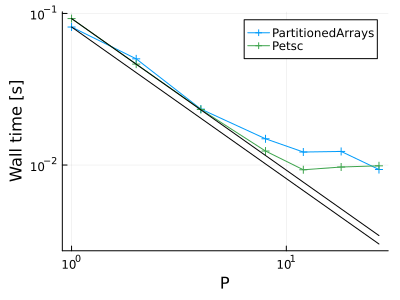

In [272]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["PartitionedArrays","Petsc"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:spmv]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,label=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

## Matrix assembly

In [236]:
#parts_per_dir_space = [(1,1,1),(2,1,1),(3,1,1),(4,1,1)]
parts_per_dir_space = parts_per_dir_array((3,3,3),3)
methods_space = ["psprse","petsc_coo"]
param_space = Dict(
    :nodes => 1,
    :ntasks_per_node => Derived(:parts_per_dir,prod),
    :np => Derived(:parts_per_dir,prod),
    :method => methods_space,
    :cells_per_dir => [(400,400,400)],
    :parts_per_dir => parts_per_dir_space,
    :nruns => 10,
    :benchmark => :benchmark_psparse,
)
params = dict_list(param_space)
for params in params
    produce_or_load(params;filename,tag=false) do params
        pb.runjob(cmd,params;filename)
        Dict{String,Any}()
    end
end

In [274]:
files = readdir(path)
files = filter(f->occursin("_results",f),files)
dicts = map(f->load(joinpath(path,f)),files)
dicts = filter(d->d["benchmark"]=== :benchmark_psparse,dicts)
df = DataFrame(dicts)
df[!,:buildmat] = reduce_timing.(df[!,:buildmat])
df[!,:rebuildmat] = reduce_timing.(df[!,:rebuildmat])
sort!(df,[:method,:np])
cells_per_dir = (400,400,400)
df = filter(row->row.cells_per_dir == cells_per_dir,df)

Row,nodes,cells_per_dir,method,parts_per_dir,buildmat,np,ntasks_per_node,nruns,rebuildmat,benchmark
,Int64,Tuple…,String,Tuple…,Float64,Int64,Int64,Int64,Float64,Symbol
1,1,"(400, 400, 400)",petsc_coo,"(1, 1, 1)",34.774,1,1,10,16.5492,benchmark_psparse
2,1,"(400, 400, 400)",petsc_coo,"(1, 1, 2)",32.691,2,2,10,15.4281,benchmark_psparse
3,1,"(400, 400, 400)",petsc_coo,"(1, 2, 2)",16.9239,4,4,10,7.94424,benchmark_psparse
4,1,"(400, 400, 400)",petsc_coo,"(2, 2, 2)",8.6484,8,8,10,4.12046,benchmark_psparse
5,1,"(400, 400, 400)",petsc_coo,"(2, 2, 3)",6.16582,12,12,10,2.84845,benchmark_psparse
6,1,"(400, 400, 400)",petsc_coo,"(2, 3, 3)",4.39006,18,18,10,2.07548,benchmark_psparse
7,1,"(400, 400, 400)",petsc_coo,"(3, 3, 3)",5.09085,27,27,10,2.63153,benchmark_psparse
8,1,"(400, 400, 400)",psprse,"(1, 1, 1)",15.969,1,1,10,0.391793,benchmark_psparse
9,1,"(400, 400, 400)",psprse,"(1, 1, 2)",8.62481,2,2,10,0.192918,benchmark_psparse


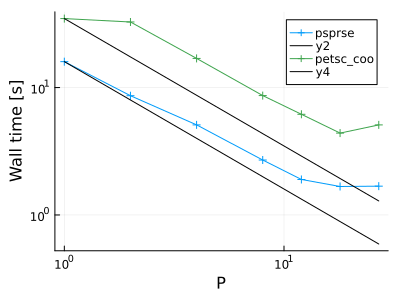

In [275]:
plt = plot(size=(400,300),xlabel="P",ylabel="Wall time [s]")
for method in ["psprse","petsc_coo"]
    take_row(row) = row.method == method && row.cells_per_dir == cells_per_dir
    df_filtered = filter(take_row,df)
    sort!(df_filtered,[:np])
    x = df_filtered[:,:np]
    y = df_filtered[:,:buildmat]
    plot!(x,y,label=method,markers=:auto,xaxis=:log,yaxis=:log)
    o = optimal(x,y)
    plot!(x,o,markers=:none,color=:black,xaxis=:log,yaxis=:log)
end
plt

In [7]:
; squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            236925      defq prun-job   glu250  R 1-02:34:53      1 node004
            243414      defq 1eef5d0b fverdugo  R       0:17      2 node[001-002]
            243415      defq 8a5b2e10 fverdugo  R       0:17      2 node[014-015]
            243416      defq 8c5a3841 fverdugo  R       0:17      2 node[033-034]
            243417      defq 5bb33689 fverdugo  R       0:17      2 node[022,031]
            243418      defq ab64ad83 fverdugo  R       0:17      2 node[025-026]
            243419      defq 2673950c fverdugo  R       0:17      2 node[011-012]
            243420      defq 69f3a0fd fverdugo  R       0:17      2 node[016-017]
            243421      defq 8d4cdd06 fverdugo  R       0:17      2 node[018-019]
            243422      defq f7a8e953 fverdugo  R       0:17      2 node[013,023]
            243423      defq b450c6f0 fverdugo  R       0:17      2 node[006-007]
            243424 

In [8]:
; ls results

01293a4bbdc2051c.e
01293a4bbdc2051c.jld2
01293a4bbdc2051c.o
01293a4bbdc2051c.sh
060a76c710844502.e
060a76c710844502.jld2
060a76c710844502.o
060a76c710844502.sh
060a76c710844502_results.jld2
070cef8b76242cce.e
070cef8b76242cce.jld2
070cef8b76242cce.o
070cef8b76242cce.sh
070cef8b76242cce_results.jld2
0d27d49aa8085b5f.e
0d27d49aa8085b5f.jld2
0d27d49aa8085b5f.o
0d27d49aa8085b5f.sh
0e88bcc8a1297532.e
0e88bcc8a1297532.jld2
0e88bcc8a1297532.o
0e88bcc8a1297532.sh
0e88bcc8a1297532_results.jld2
12060063dd9df972.e
12060063dd9df972.jld2
12060063dd9df972.o
12060063dd9df972.sh
12060063dd9df972_results.jld2
16487d2bb78173de.e
16487d2bb78173de.jld2
16487d2bb78173de.o
16487d2bb78173de.sh
16487d2bb78173de_results.jld2
170e0183d45c9e57.e
170e0183d45c9e57.jld2
170e0183d45c9e57.o
170e0183d45c9e57.sh
193e0d423777d28d.e
193e0d423777d28d.jld2
193e0d423777d28d.o
193e0d423777d28d.sh
1aba1468b94616c3.e
1aba1468b94616c3.jld2
1aba1468b94616c3.o
1aba1468b94616c3.sh
1aba1468b94616c3_results.jld2
1c5ae48699c92774.e
1

In [9]:
; cat results/060a76c710844502.sh

#!/bin/bash
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=2
#SBATCH --output=results/060a76c710844502.o
#SBATCH --error=results/060a76c710844502.e

julia --project=/home/fverdugo/code/PartitionedArrays.jl/PartitionedArraysBenchmarks/analysis/Project.toml -O3 --check-bounds=no -e '
code = quote
   import PartitionedArraysBenchmarks as pb
   import PartitionedArrays as pa
   params = (np = 2, method = "petsc_coo", benchmark = :benchmark_psparse, cells_per_dir = (400, 400, 400), nodes = 1, parts_per_dir = (1, 1, 2), ntasks_per_node = 2, nruns = 10)
   jobname = "results/060a76c710844502"
   pa.with_mpi() do distribute
       pb.experiment(pb.benchmark_psparse,jobname,distribute,params)
   end
end
using MPI
cmd = mpiexec()
run(`$cmd -np 2 julia --project=/home/fverdugo/code/PartitionedArrays.jl/PartitionedArraysBenchmarks/analysis/Project.toml -O3 --check-bounds=no -e $code`)
'
